<a href="https://colab.research.google.com/github/mbcruz96/AutoEncoder/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dependencies

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import argparse
import numpy as np

#Model Architecture

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.fcl1 = nn.Linear(32*3*3, 128)
        #self.fcl2 = nn.Linear(256, 128)
        self.fcl3 = nn.Linear(128, 10)
   # flattening function
    def num_flat_features(self, x):
      '''
      calculates the flattened vector for input into the fully connected layers
      '''
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features

    def forward(self, x):
      #print(x.size())
      x = F.max_pool2d(F.relu(self.conv1(x)), 2)
      #print(x.size())
      x = F.max_pool2d(F.relu(self.conv2(x)), 2)
      #print (x.size())
      x = F.max_pool2d(F.relu(self.conv3(x)), 2)
      #print (x.size())
      x = x.view(-1, self.num_flat_features(x))
      #print (x.size())
      x = F.relu(self.fcl1(x))
      #print (x.size())
      #x = F.relu(self.fcl2(x))
      x = self.fcl3(x)
      #print (x.size())
      return x


In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fcl1 = nn.Linear(10, 128)
        self.fcl2 = nn.Linear(128, 3*3*32)
        #self.fcl3 = nn.Linear(256, 784)
        self.conv1 = nn.ConvTranspose2d(32, 16, 3, output_padding=0, stride=2)
        self.conv2 = nn.ConvTranspose2d(16, 8, 3, output_padding=1, padding=1, stride=2)
        self.conv3 = nn.ConvTranspose2d(8, 1, 3, output_padding=1, padding=1, stride=2)
        self.norm1 = nn.BatchNorm2d(16)
        self.norm2 = nn.BatchNorm2d(8)
        self.unflatten = nn.Unflatten(1, (32, 3, 3))
        self.upsample = nn.Upsample(scale_factor=(2, 2), mode='bilinear')

    def forward(self, x):
      x = F.relu(self.fcl1(x))
      #print('fcl1 done: ', x.size())
      x = F.relu(self.fcl2(x))
      #print('fcl2 done: ', x.size())
      #x = F.relu(self.fcl3(x))
      #print('fcl2 done: ', dec.size())
      x = self.unflatten(x)
      #print(x.size())
      x = F.relu(self.conv1(x))
      x = self.norm1(x)
      #print('conv1 done: ', x.size())
      #x = self.upsample(x)
      #print('up done: ', x.size())
      x = F.relu(self.conv2(x))
      x = self.norm2(x)
      #print('conv2 done: ', x.size())
      #x = self.upsample(x)
      #print('up done: ', x.size())
      x = F.sigmoid(self.conv3(x))
      #print('conv3 done: ', x.size())
      return x

#Training and Testing

In [ ]:
def train(encoder, decoder, device, train_loader, optimizer, criterion, epoch, batch_size):
  encoder.train()
  decoder.train()

  losses = []
  correct = 0

  for batch_idx, batch_sample in enumerate(train_loader):
    data, target = batch_sample

    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    output = encoder(data)
    output = decoder(output)
    #print('image size: ', data.size())
    #print('output size: ', output.size())

    loss = criterion(output, data)

    loss.backward()


    losses.append(loss.item())

    optimizer.step()

  train_loss = float(np.mean(losses))

  print('\nTrain set: Average loss: {:.4f}'.format(train_loss))
  return train_loss

In [ ]:
def test(encoder, decoder, device, test_loader, criterion):
  encoder.eval()
  decoder.eval()

  losses = []
  correct = 0

  with torch.no_grad():
    for batch_idx, sample in enumerate(test_loader):
      data, target = sample

      data, target = data.to(device), target.to(device)

      output = encoder(data)
      output = decoder(output)

      loss = criterion(output, data)

      losses.append(loss.item())

    test_loss = float(np.mean(losses))

    print('Test set: Average loss: {:.4f}'.format(test_loss))

    return test_loss

In [ ]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = dataset2.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = dataset2[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

#Training loop

Torch device selected:  cuda


100%|██████████| 9912422/9912422 [00:00<00:00, 274917088.17it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 15888732.14it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 80826171.88it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14366914.61it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Train set: Average loss: 1.2535
Test set: Average loss: 1.1789


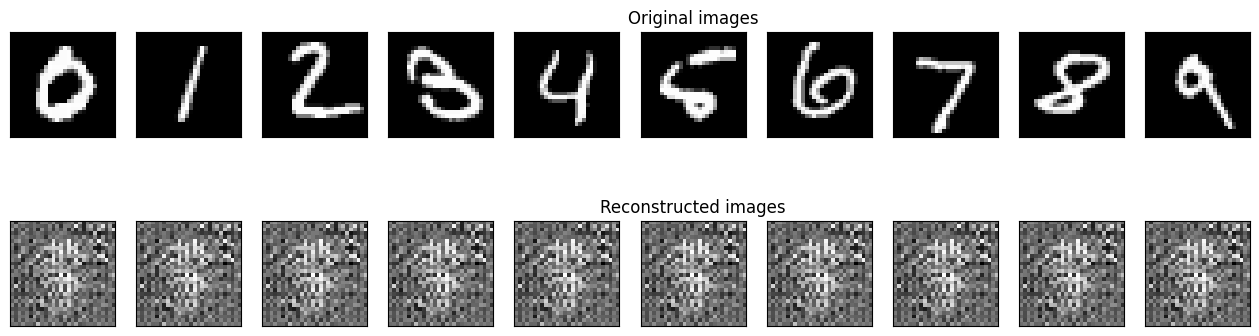


Train set: Average loss: 1.1004
Test set: Average loss: 1.0467


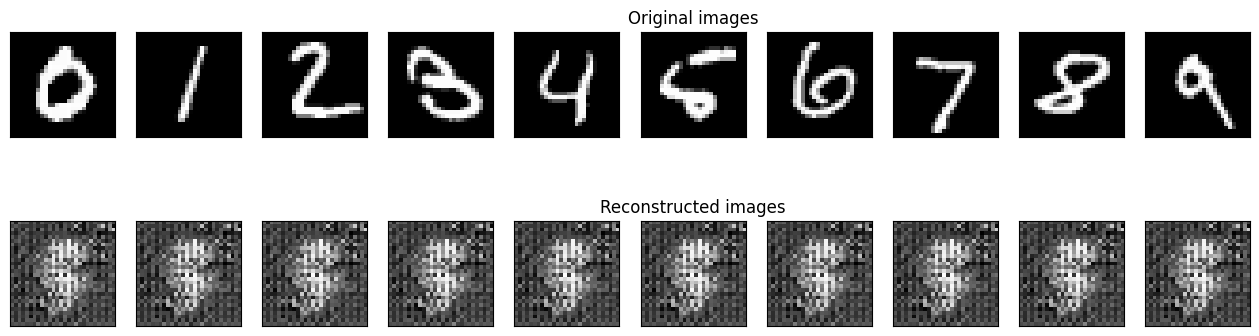


Train set: Average loss: 0.9939
Test set: Average loss: 0.9619


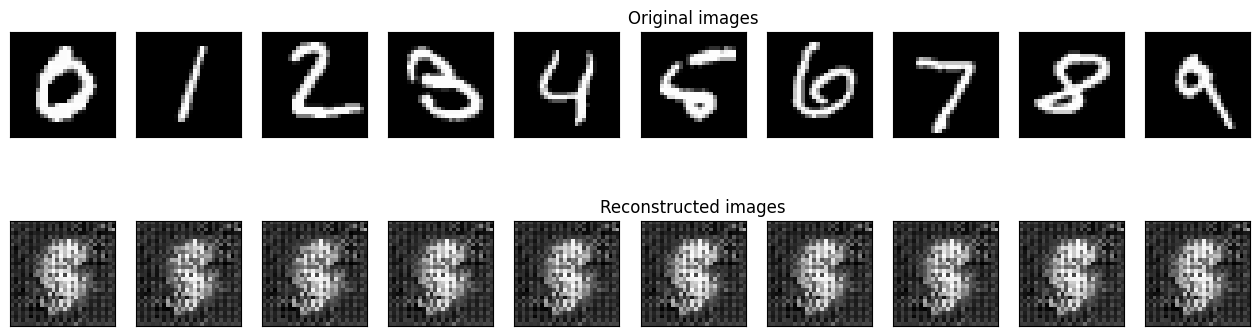


Train set: Average loss: 0.9239
Test set: Average loss: 0.9023


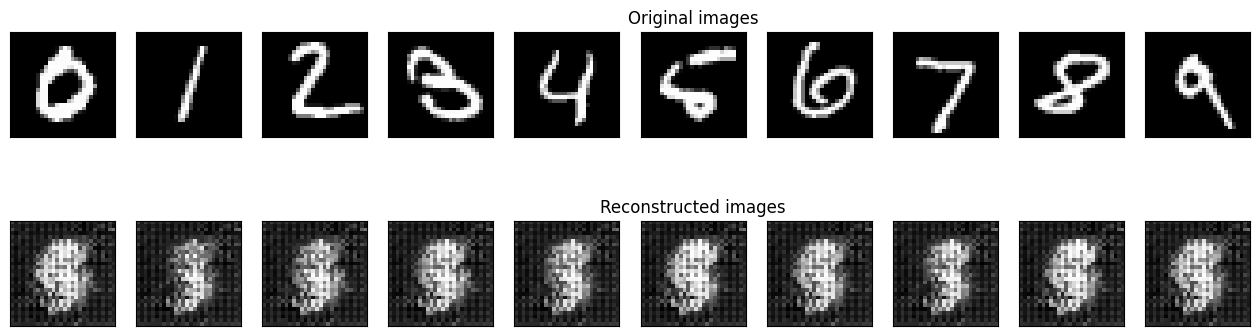


Train set: Average loss: 0.8731
Test set: Average loss: 0.8574


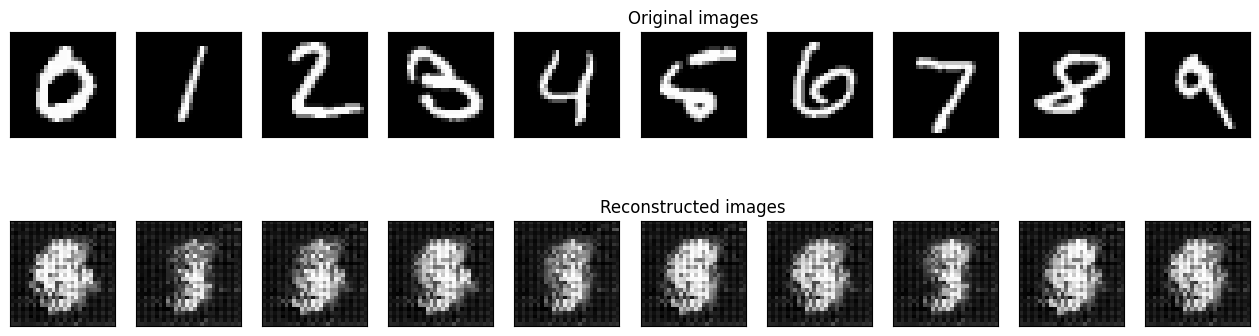


Train set: Average loss: 0.8333
Test set: Average loss: 0.8207


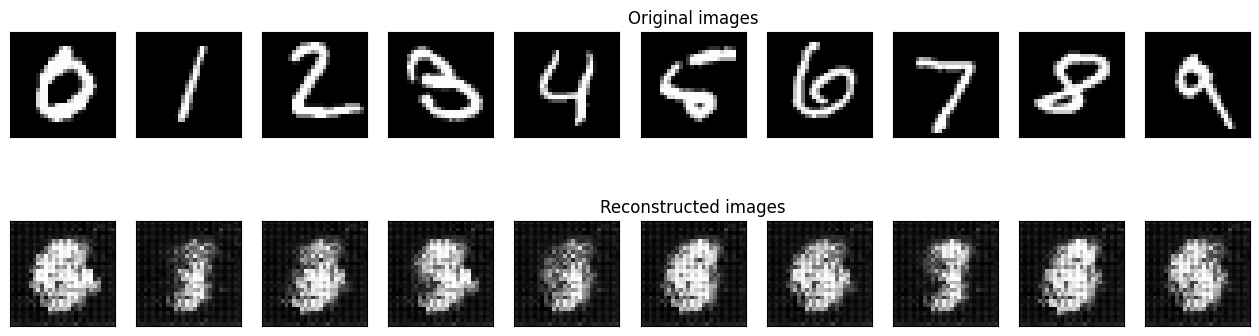


Train set: Average loss: 0.8011
Test set: Average loss: 0.7913


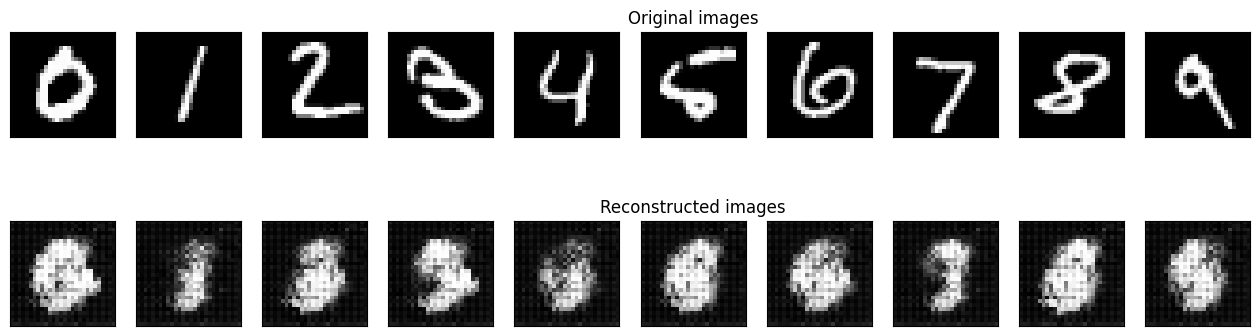


Train set: Average loss: 0.7775
Test set: Average loss: 0.7710


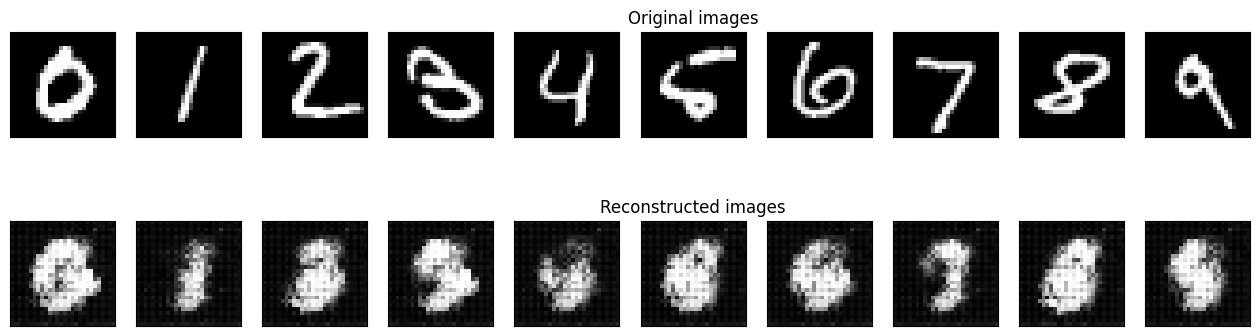


Train set: Average loss: 0.7589
Test set: Average loss: 0.7548


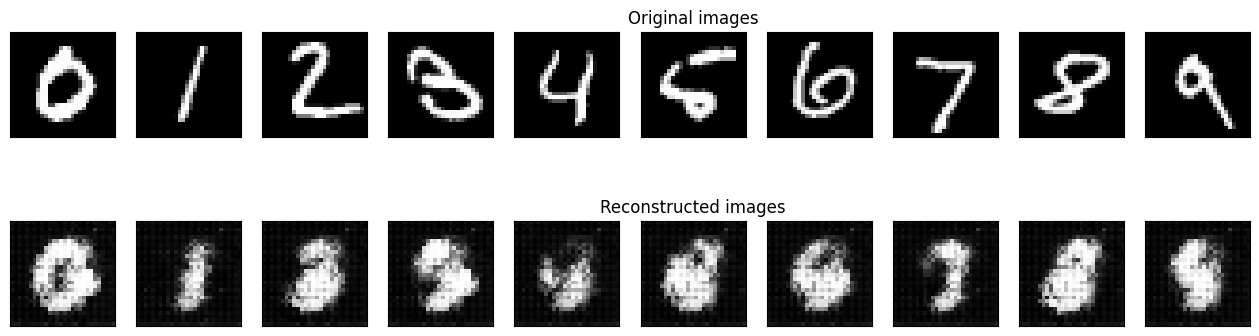


Train set: Average loss: 0.7414
Test set: Average loss: 0.7362


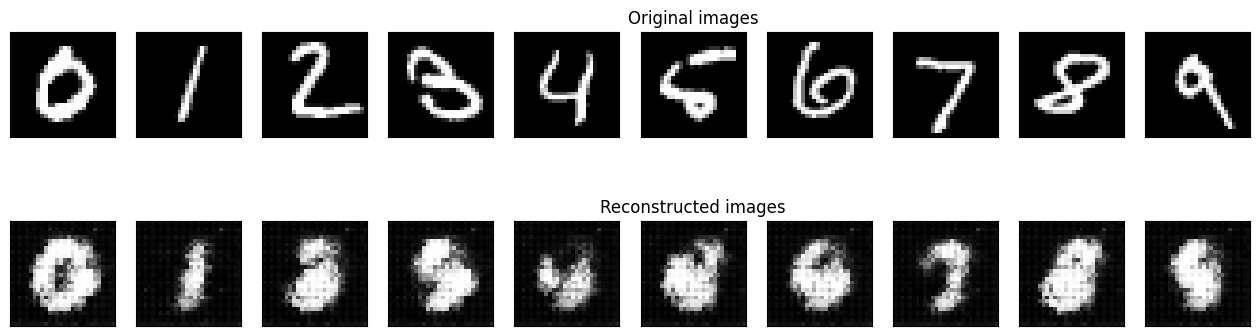


Train set: Average loss: 0.7240
Test set: Average loss: 0.7189


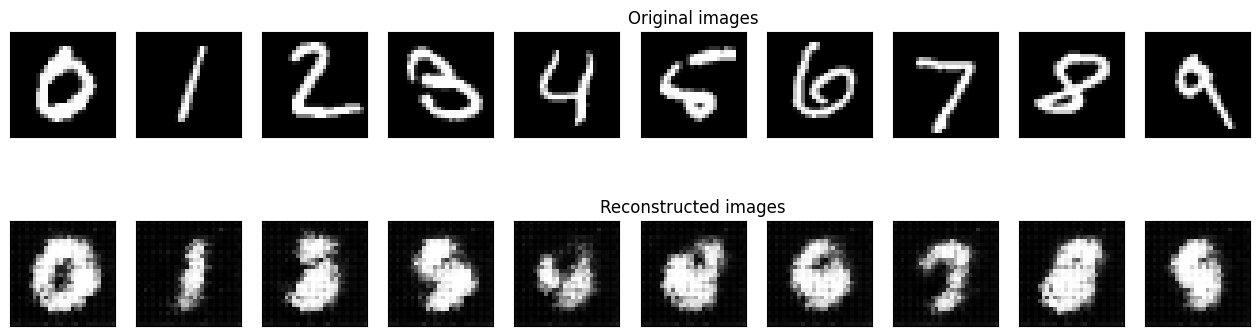


Train set: Average loss: 0.7080
Test set: Average loss: 0.7039


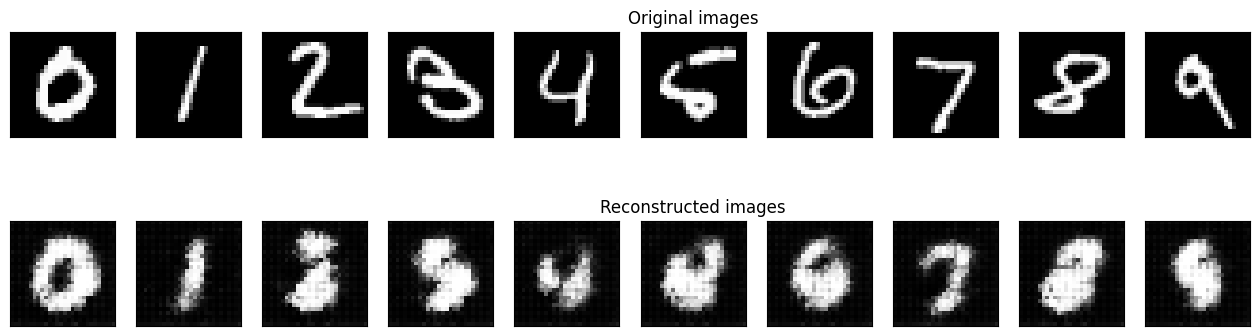


Train set: Average loss: 0.6941
Test set: Average loss: 0.6899


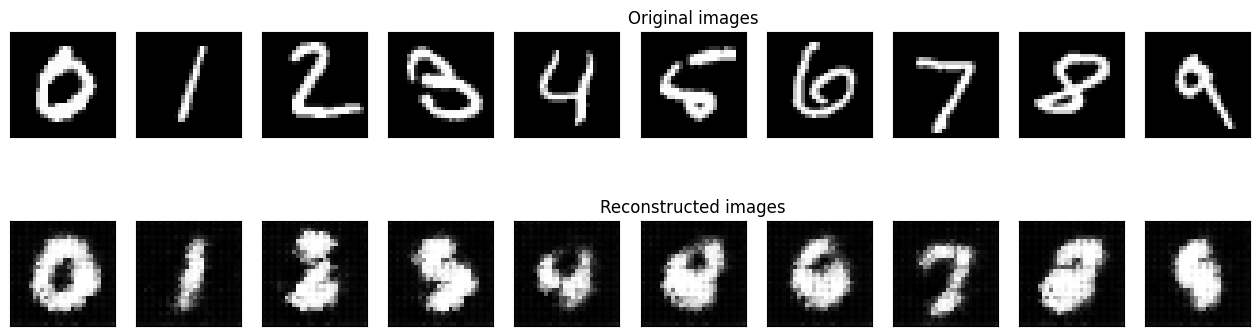


Train set: Average loss: 0.6812
Test set: Average loss: 0.6778


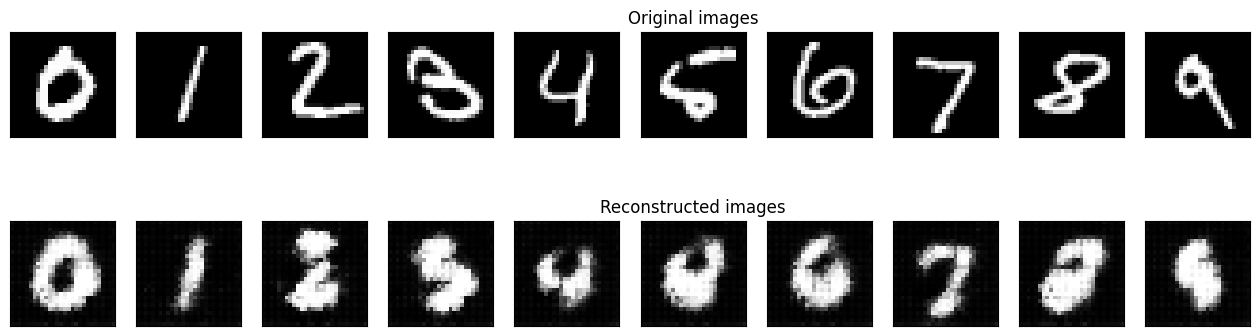


Train set: Average loss: 0.6706
Test set: Average loss: 0.6682


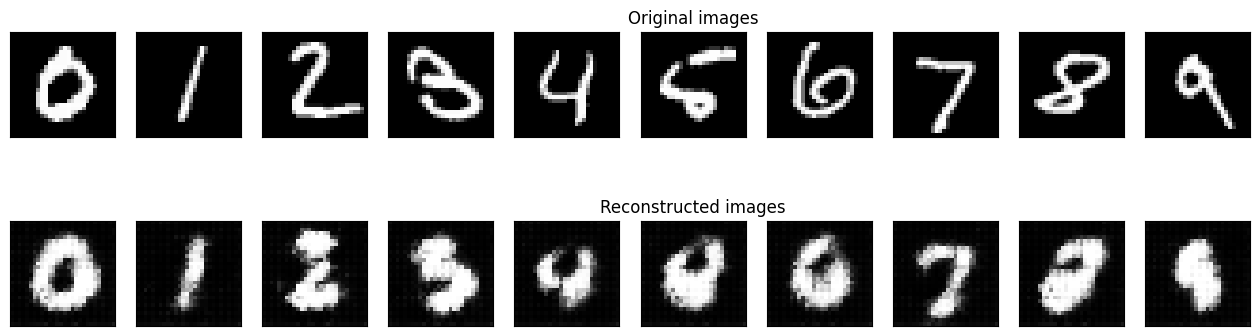


Train set: Average loss: 0.6617
Test set: Average loss: 0.6603


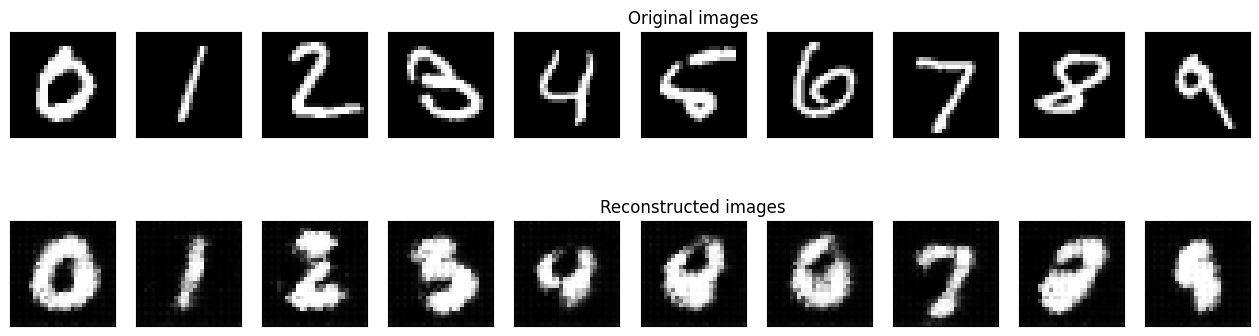


Train set: Average loss: 0.6544
Test set: Average loss: 0.6532


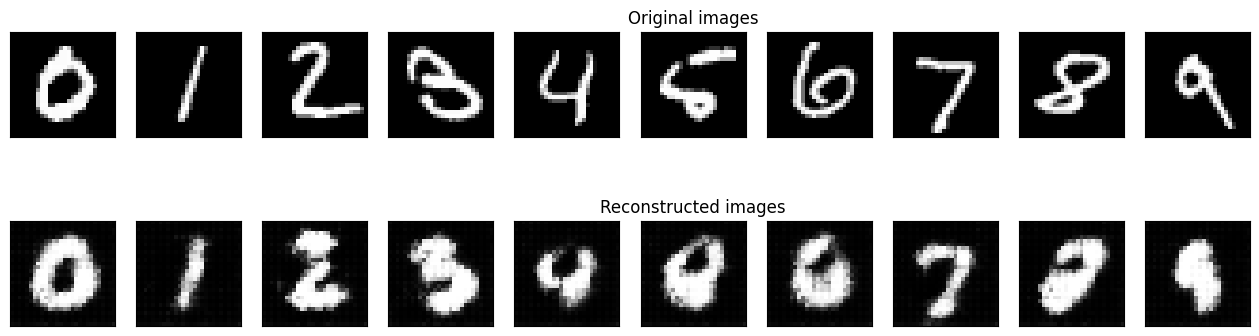


Train set: Average loss: 0.6478
Test set: Average loss: 0.6470


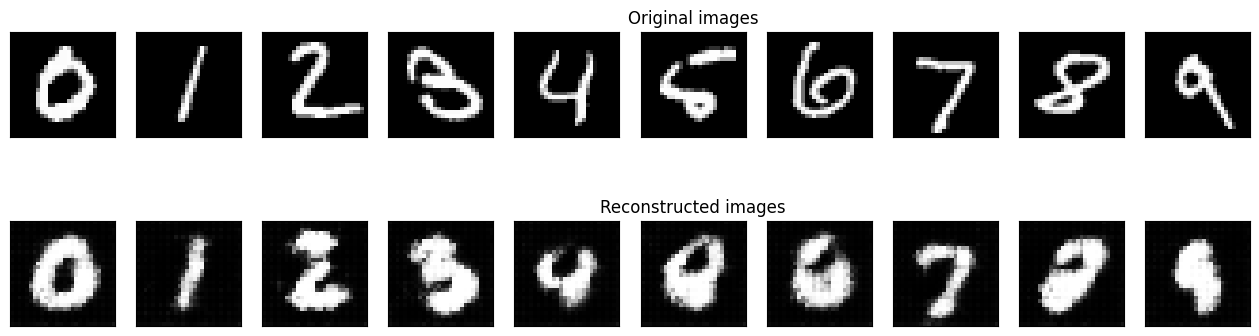


Train set: Average loss: 0.6417
Test set: Average loss: 0.6430


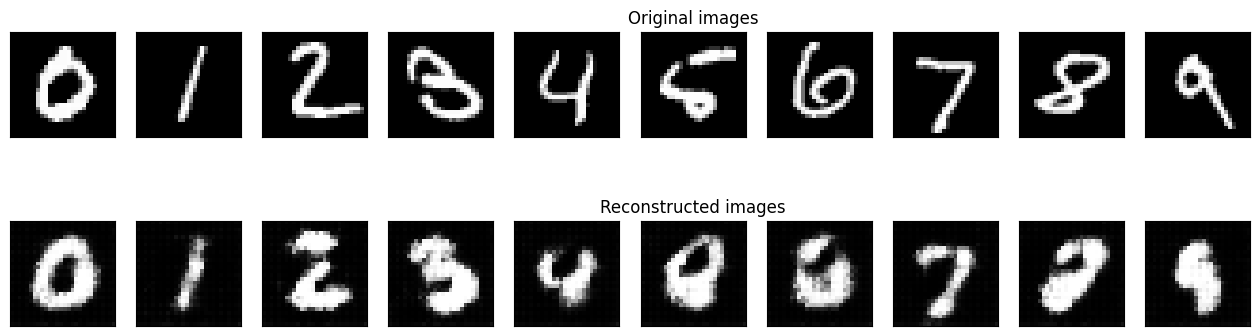


Train set: Average loss: 0.6365
Test set: Average loss: 0.6368


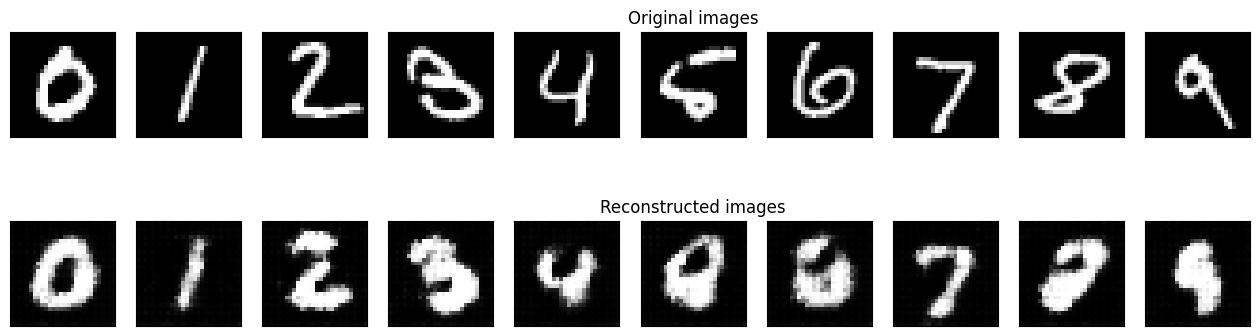


Train set: Average loss: 0.6319
Test set: Average loss: 0.6323


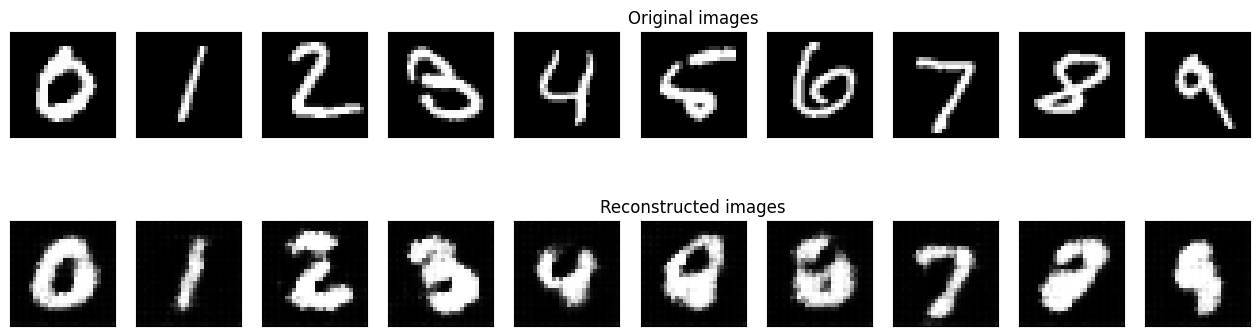


Train set: Average loss: 0.6279
Test set: Average loss: 0.6296


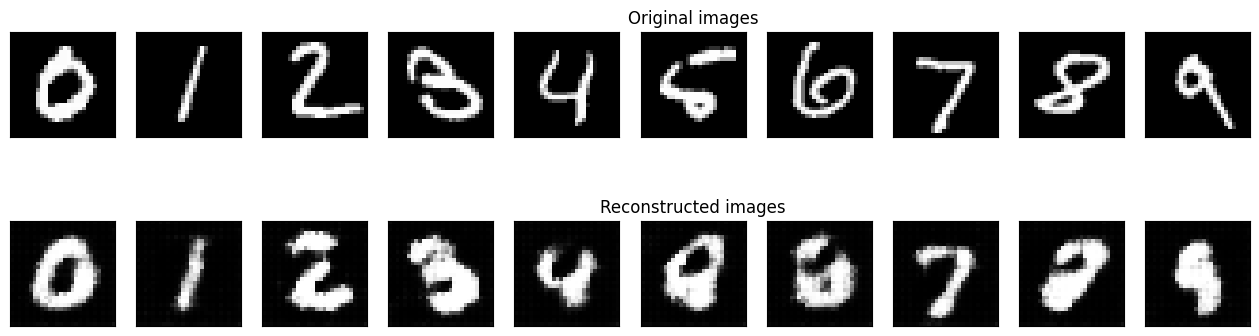


Train set: Average loss: 0.6243
Test set: Average loss: 0.6253


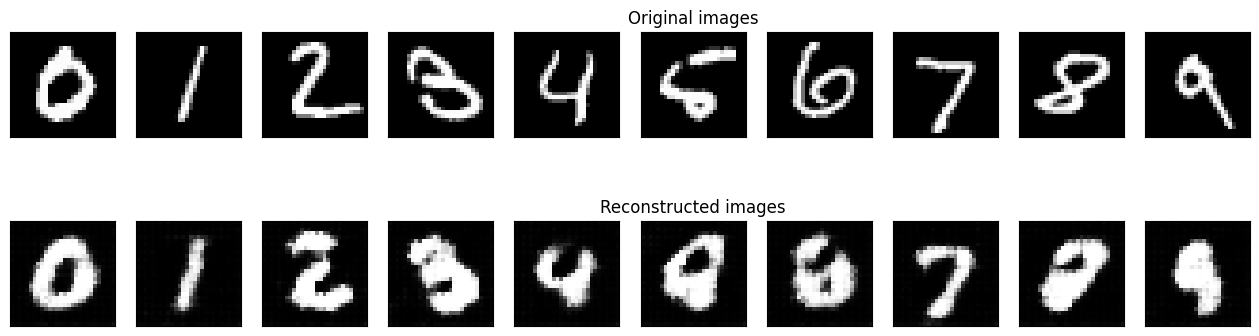


Train set: Average loss: 0.6210
Test set: Average loss: 0.6224


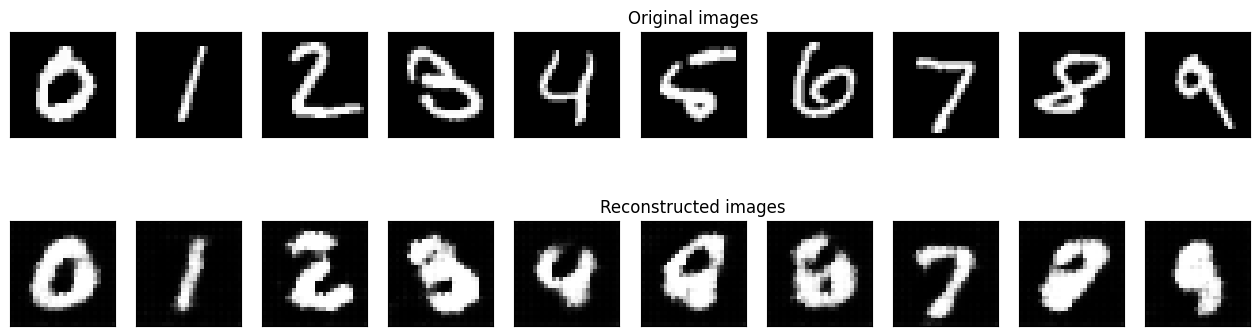


Train set: Average loss: 0.6182
Test set: Average loss: 0.6197


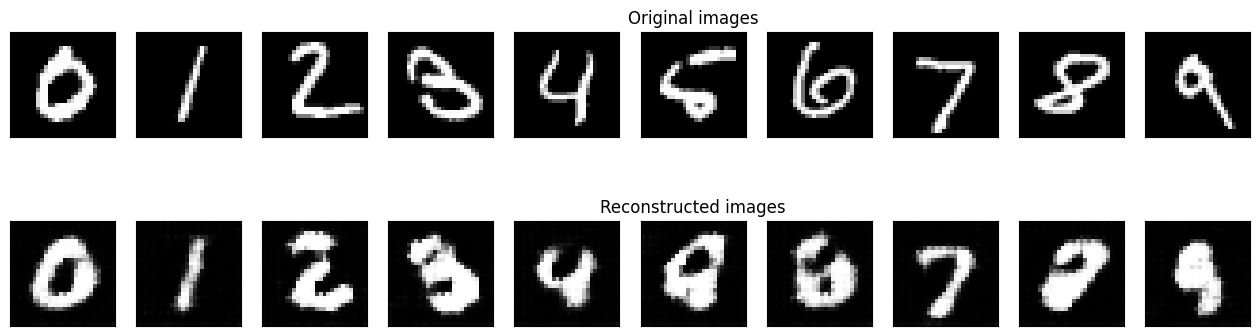


Train set: Average loss: 0.6155
Test set: Average loss: 0.6169


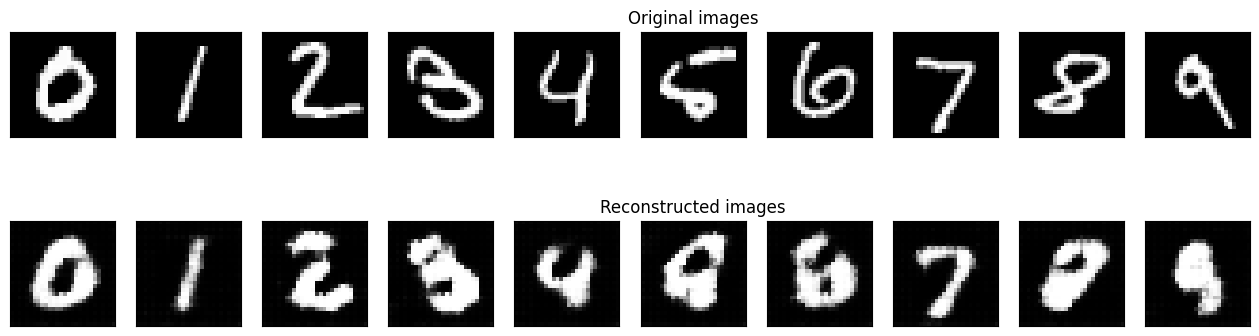


Train set: Average loss: 0.6131
Test set: Average loss: 0.6159


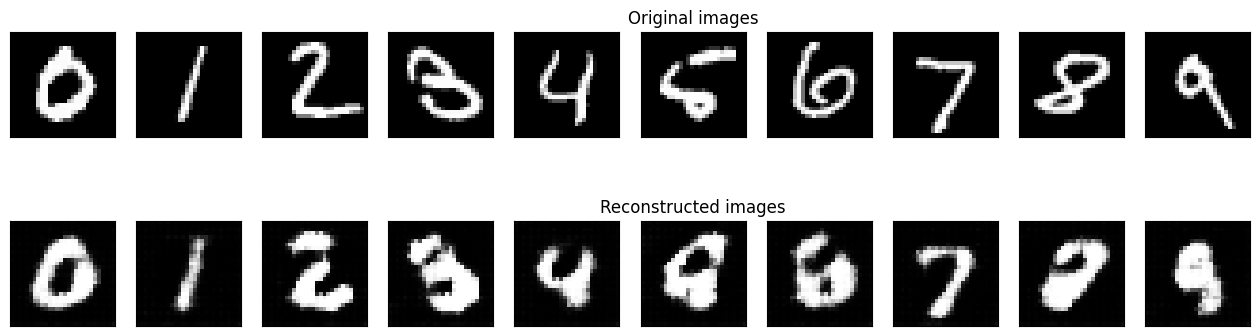


Train set: Average loss: 0.6110
Test set: Average loss: 0.6128


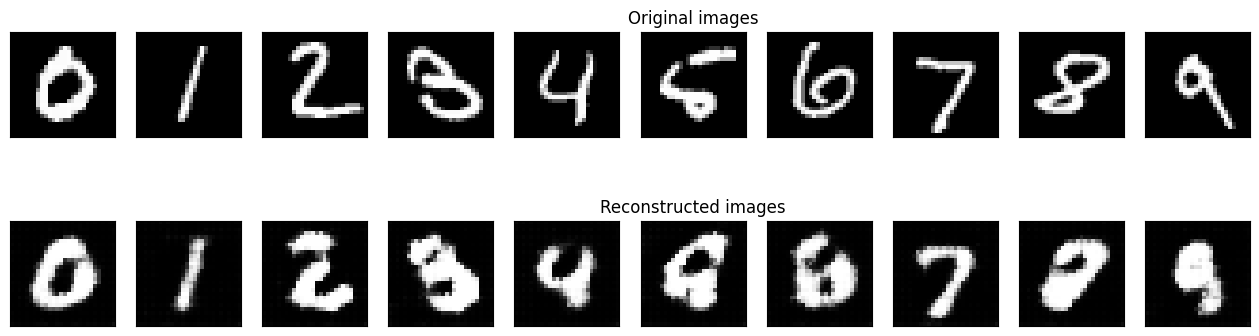


Train set: Average loss: 0.6090
Test set: Average loss: 0.6109


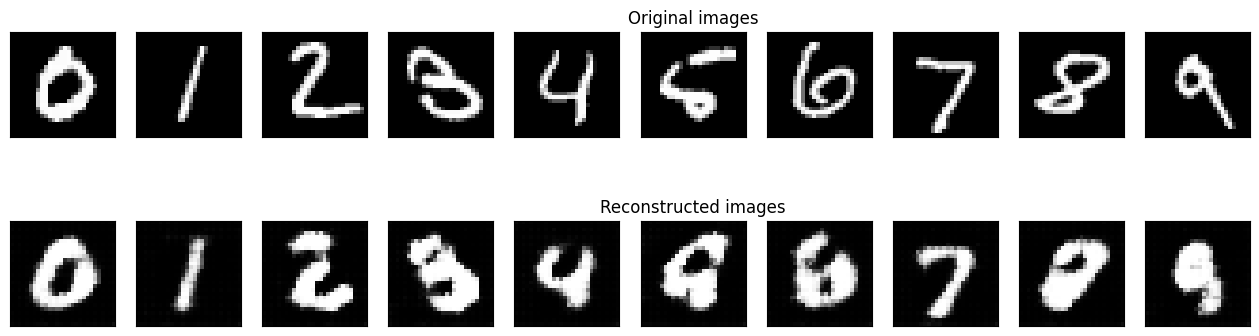


Train set: Average loss: 0.6072
Test set: Average loss: 0.6093


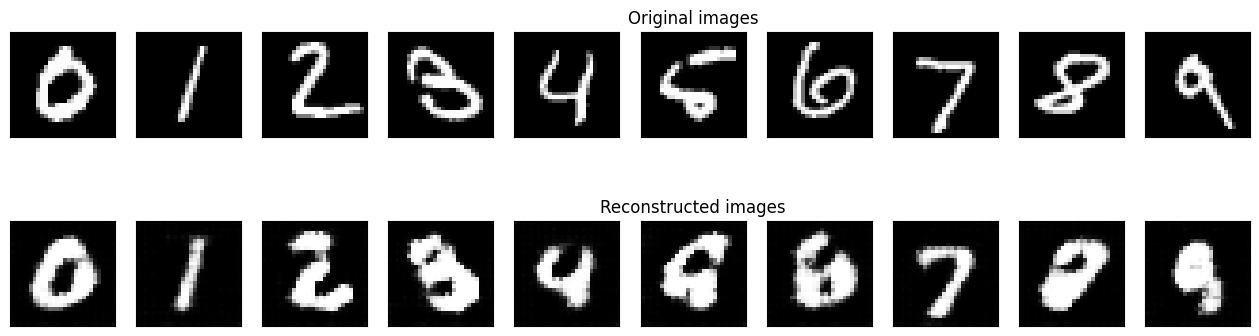


Train set: Average loss: 0.6055
Test set: Average loss: 0.6072


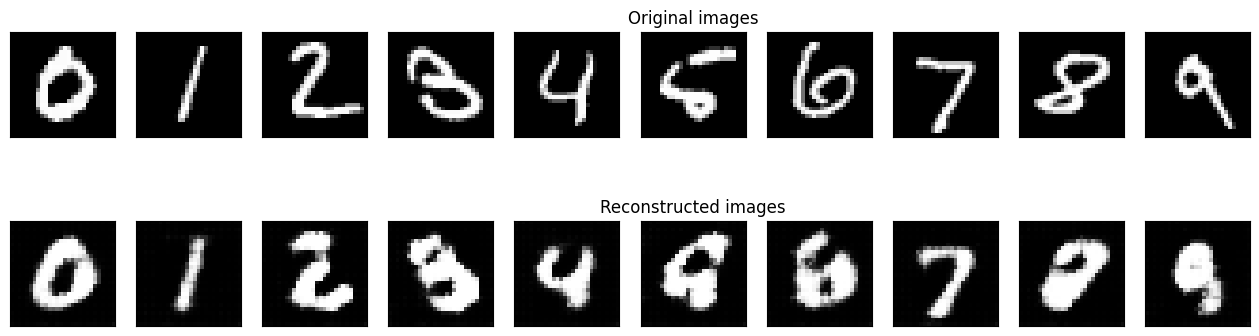


Train set: Average loss: 0.6040
Test set: Average loss: 0.6060


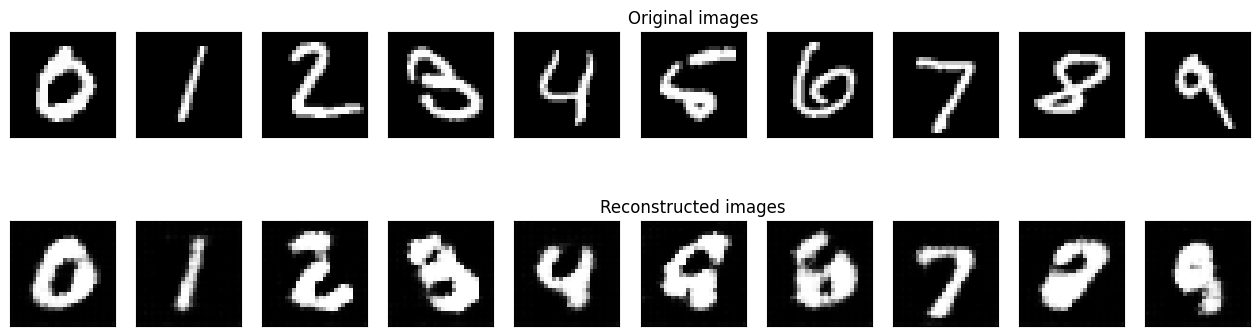


Train set: Average loss: 0.6025
Test set: Average loss: 0.6050


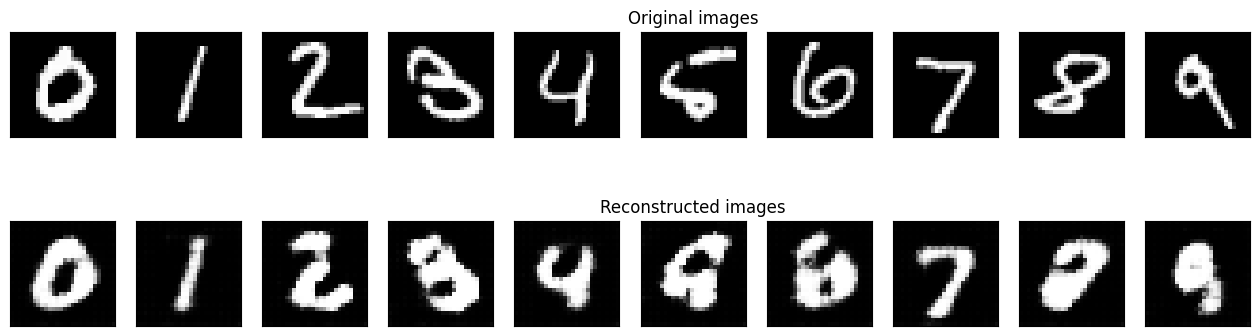


Train set: Average loss: 0.6011
Test set: Average loss: 0.6033


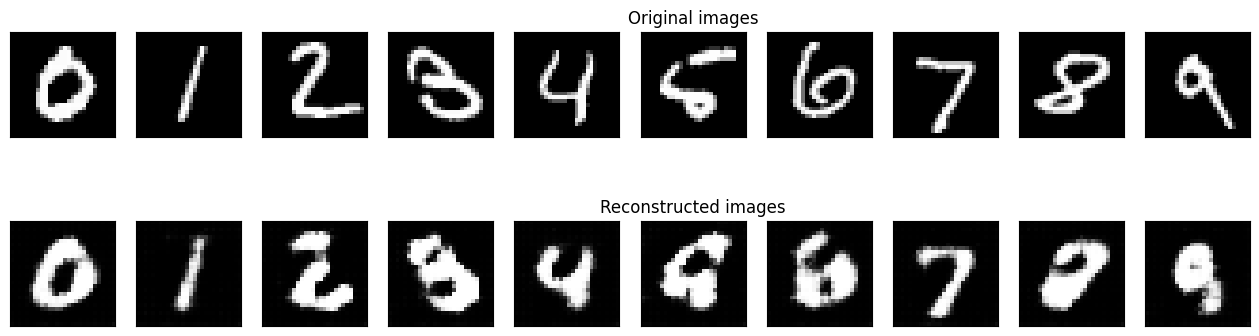


Train set: Average loss: 0.5997
Test set: Average loss: 0.6040


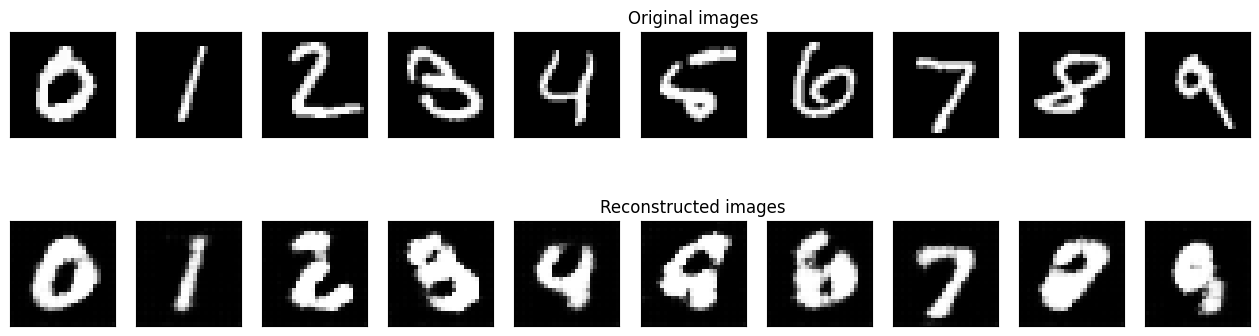


Train set: Average loss: 0.5984
Test set: Average loss: 0.6025


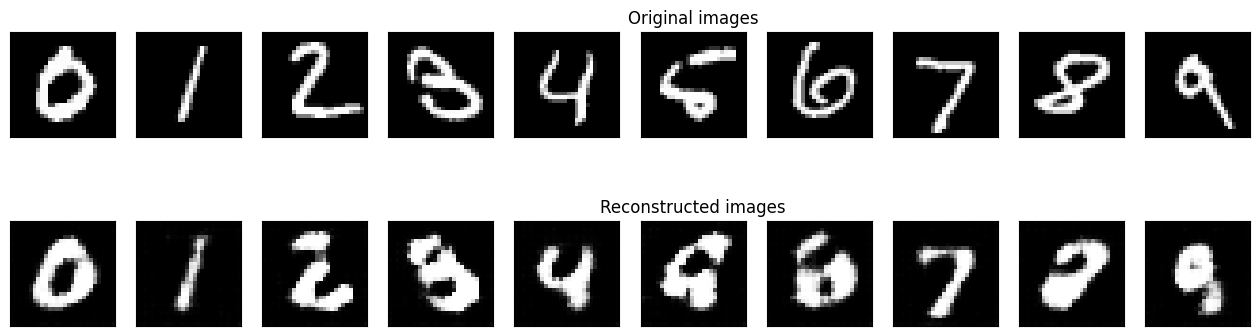


Train set: Average loss: 0.5971
Test set: Average loss: 0.5993


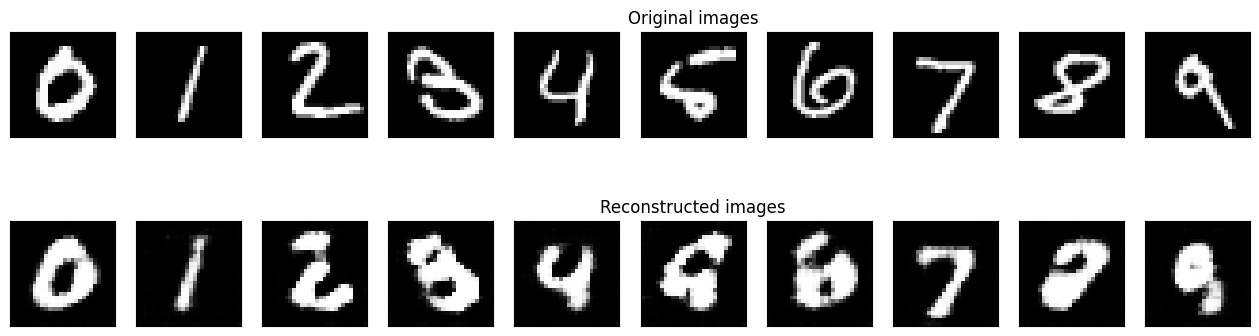


Train set: Average loss: 0.5960
Test set: Average loss: 0.5984


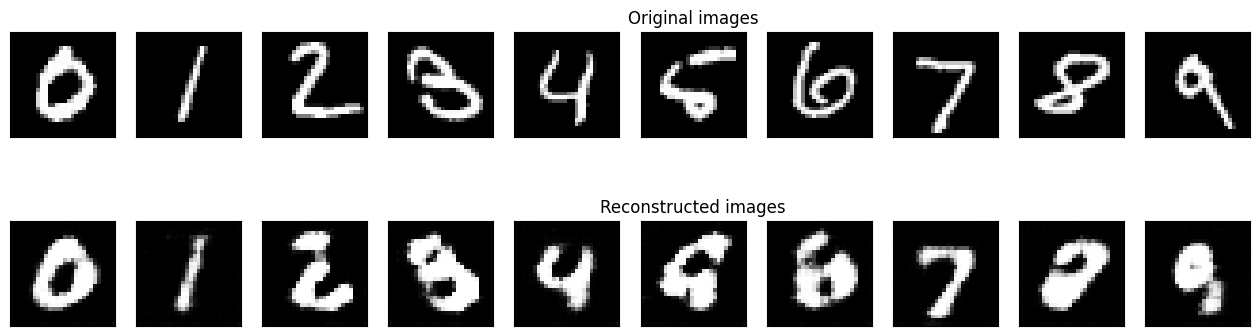


Train set: Average loss: 0.5948
Test set: Average loss: 0.5972


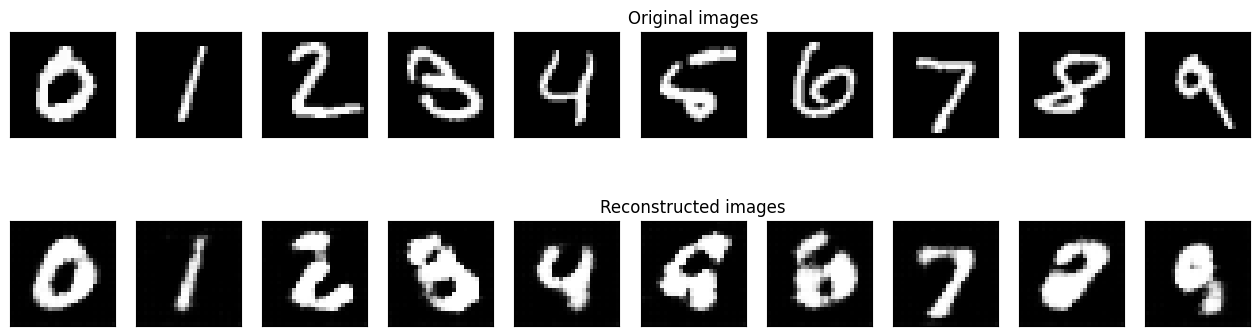


Train set: Average loss: 0.5938
Test set: Average loss: 0.5963


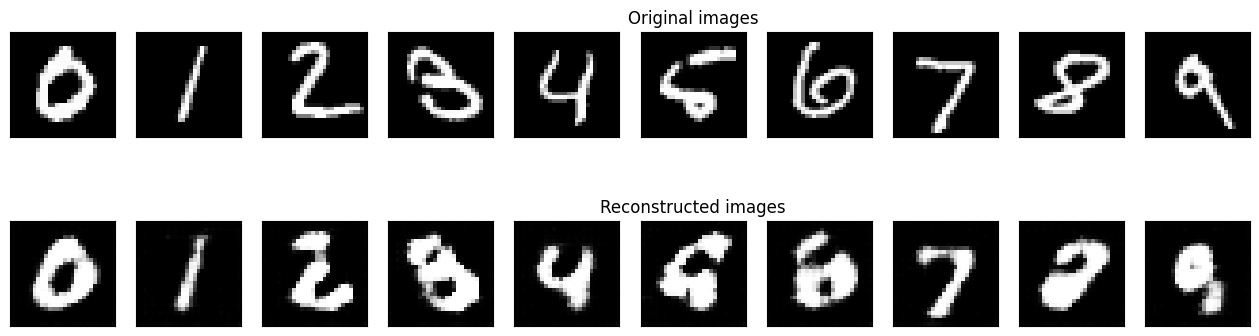


Train set: Average loss: 0.5928
Test set: Average loss: 0.5956


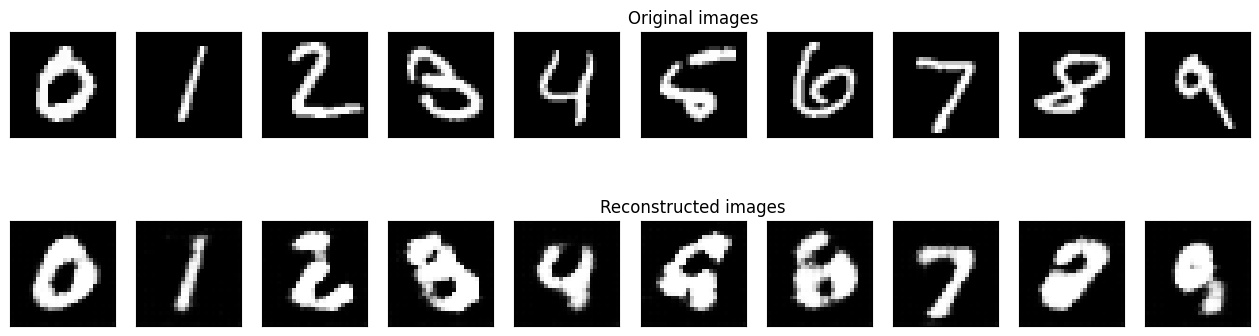


Train set: Average loss: 0.5918
Test set: Average loss: 0.5949


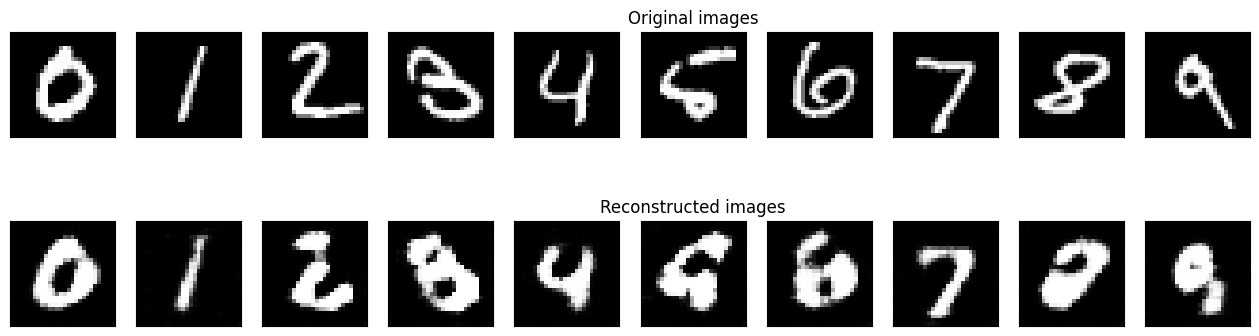


Train set: Average loss: 0.5909
Test set: Average loss: 0.5936


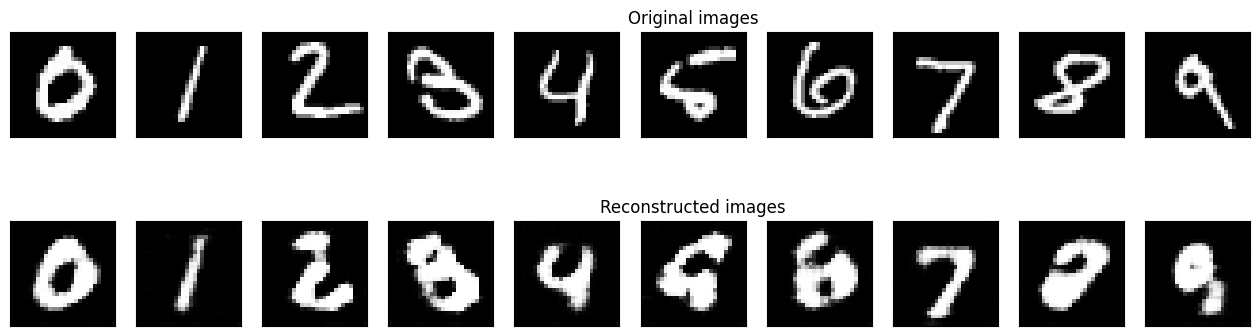


Train set: Average loss: 0.5900
Test set: Average loss: 0.5927


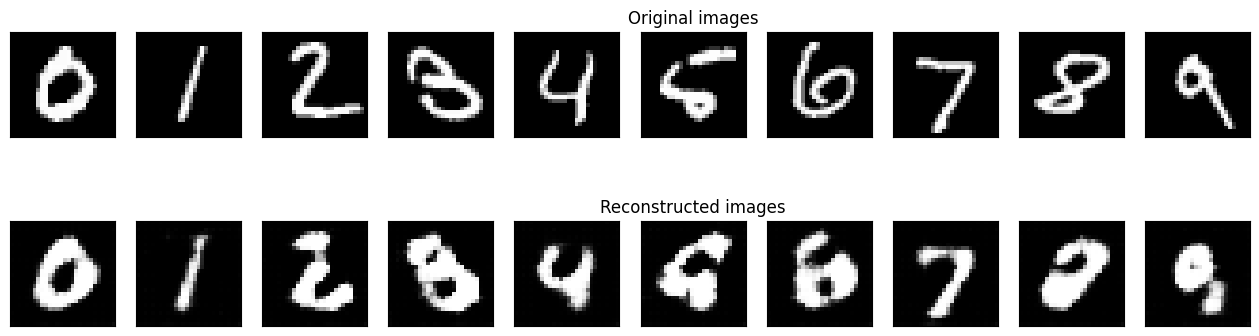


Train set: Average loss: 0.5892
Test set: Average loss: 0.5922


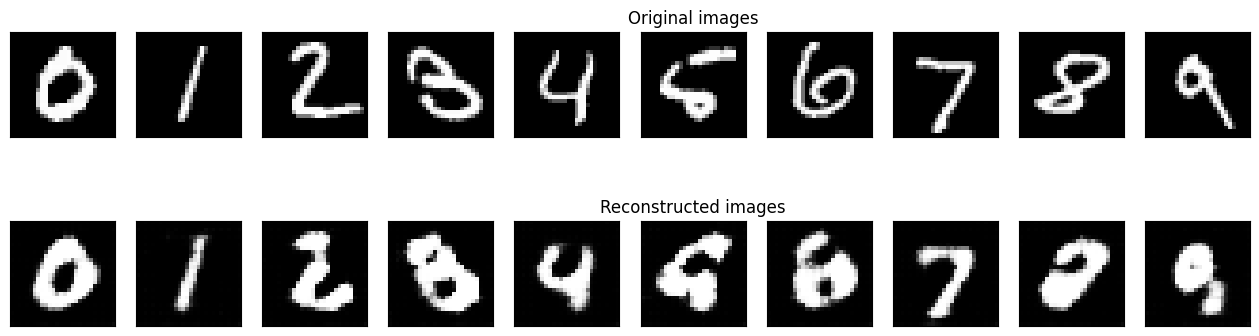


Train set: Average loss: 0.5883
Test set: Average loss: 0.5910


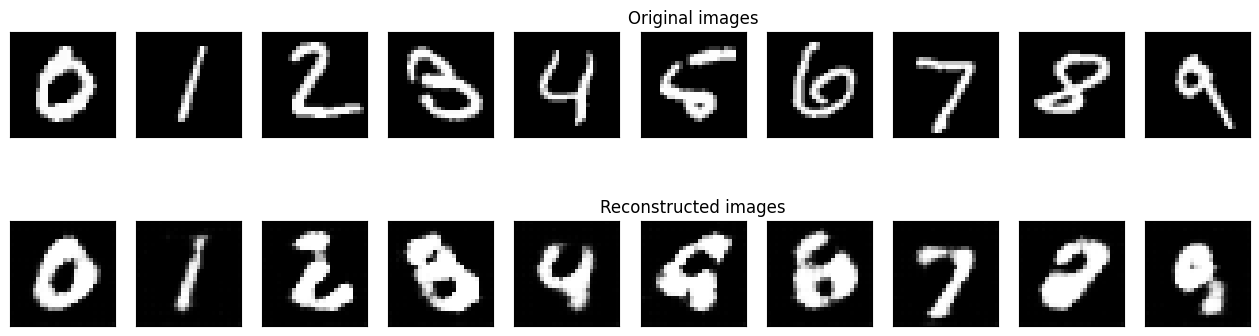


Train set: Average loss: 0.5875
Test set: Average loss: 0.5902


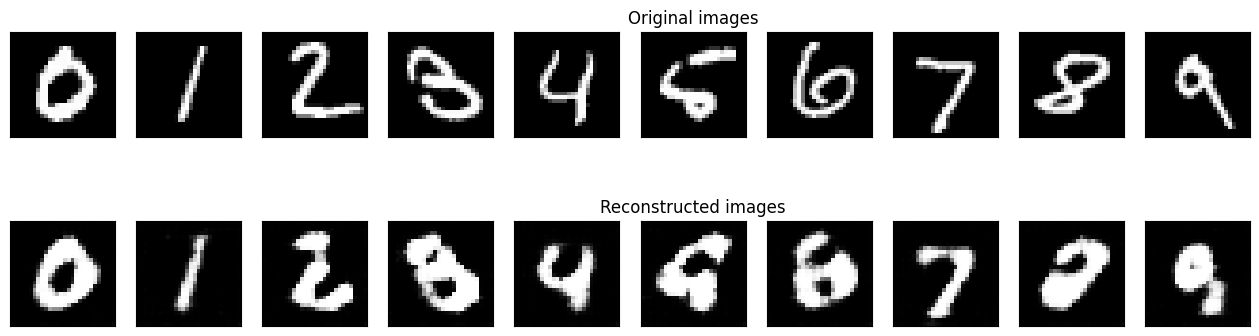


Train set: Average loss: 0.5868
Test set: Average loss: 0.5910


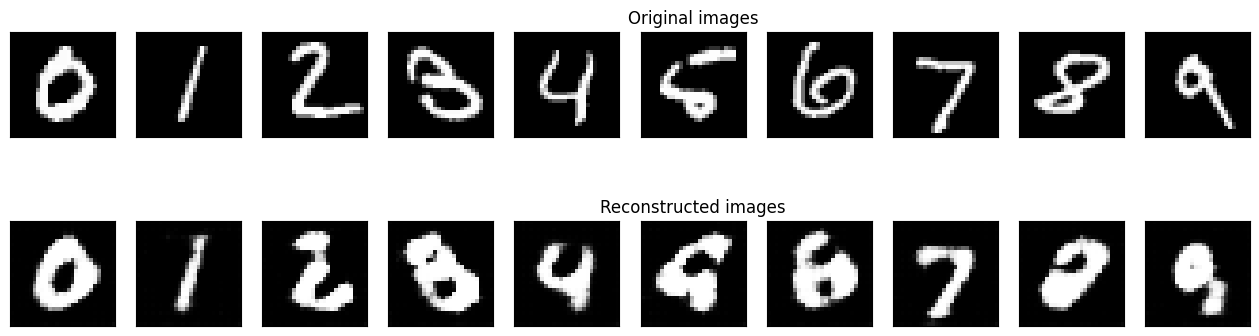


Train set: Average loss: 0.5861
Test set: Average loss: 0.5889


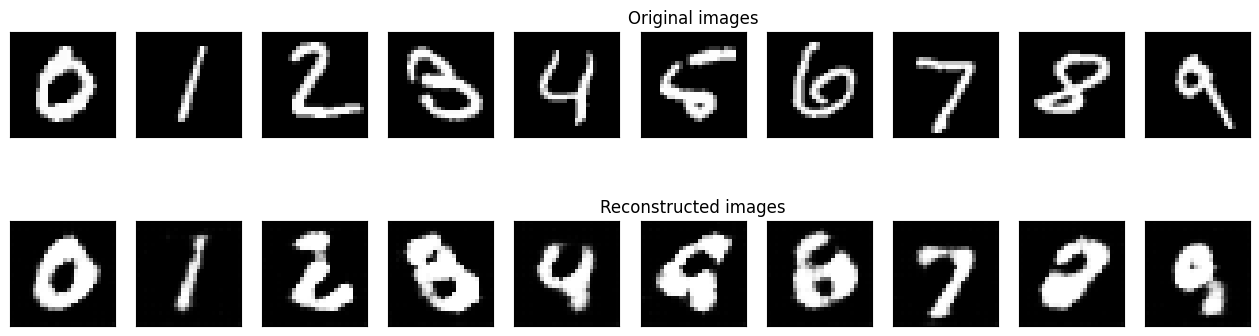


Train set: Average loss: 0.5853
Test set: Average loss: 0.5887


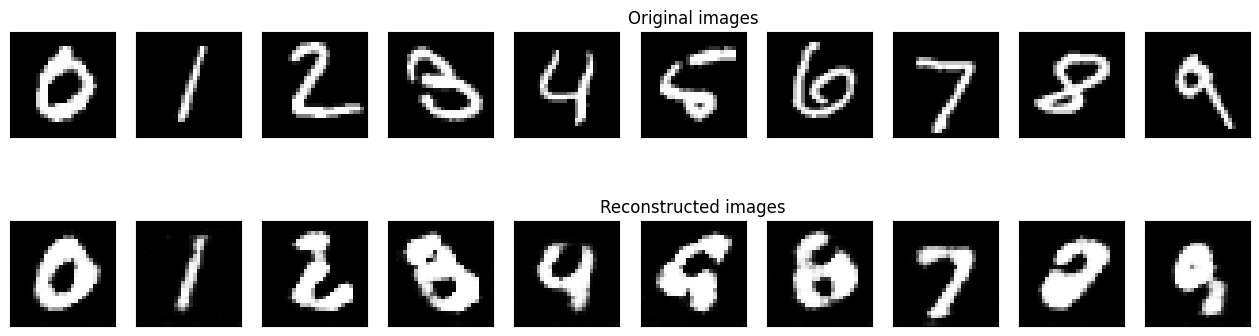

Training and evaluation finished


In [ ]:
# Hyperparameters
learning_rate = .001
num_epochs = 50
batch_size = 32

# using gpu
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print("Torch device selected: ", device)

# initializing models
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# initializing loss function
criterion = nn.MSELoss()

# model parameters
model_params = [
    {'params' : encoder.parameters()},
    {'params' : decoder.parameters()}
]

# initializing optimizer
optimizer = optim.SGD(model_params, lr=learning_rate)

# pre-processing dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081))
])

# training dataset
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
# testing dataset
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)

# initializing dataloaders
train_loader = DataLoader(dataset1, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset2, batch_size=batch_size, shuffle=False, num_workers=4)

# losses
train_loss = []
test_loss = []

for epoch in range(1, num_epochs + 1):
  loss = train(encoder, decoder, device, train_loader, optimizer, criterion, epoch, batch_size)
  train_loss.append(loss)
  loss = test(encoder, decoder, device, test_loader, criterion)
  test_loss.append(loss)
  plot_ae_outputs(encoder,decoder,n=10)
print("Training and evaluation finished")

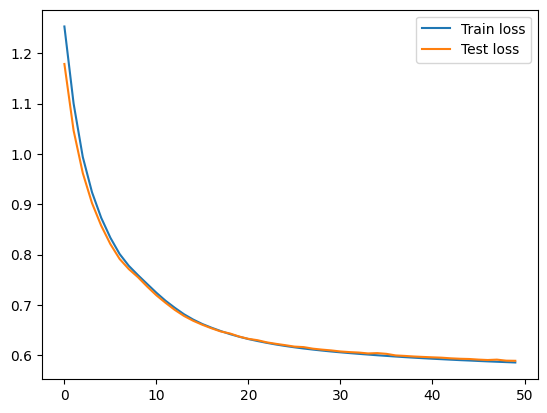

In [ ]:
# Training and test loss graph
plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')
plt.legend()
plt.show()